Importing modules

In [1]:
import pandas as pd
import numpy as np  
import re  
import nltk  
from sklearn.datasets import load_files  
nltk.download('stopwords')  
import pickle  
from nltk.corpus import stopwords  
nltk.download('wordnet')
import time
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Importing methods
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to C:\Users\Mantas
[nltk_data]     Lukauskas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mantas
[nltk_data]     Lukauskas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading files and concat them into one

In [2]:
colnames =["Review"]
pos_review = pd.read_csv("Raw data/rt-polarity_pos.csv", names=colnames, sep='|', encoding='latin-1')
pos_review["Class"] = 1
neg_review = pd.read_csv("Raw data/rt-polarity_neg.csv", names=colnames, sep='|', encoding='latin-1')
neg_review["Class"] = 0
reviews = pd.concat([pos_review, neg_review], ignore_index=True)

Information about Class distribution

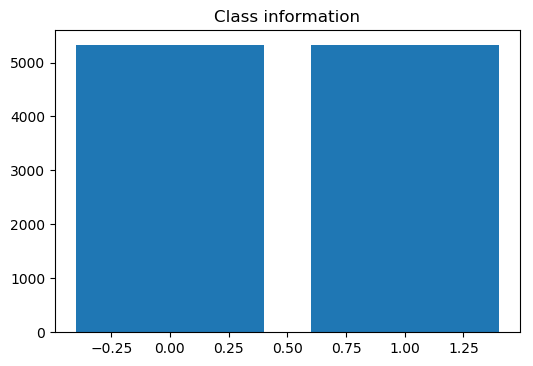

In [3]:
counter = Counter(reviews["Class"])
fig, ax = plt.subplots(dpi=100)
ax.bar(list(counter.keys()), list(counter.values()))
ax.set_title("Class information")
plt.show()

Splitting file into review and target vars

In [33]:
X, y = reviews["Review"],reviews["Class"]

Preprocess function

In [34]:
from nltk.stem import WordNetLemmatizer

def DocPreproc(X):
    
    documents = []
    
    stemmer = WordNetLemmatizer()

    for sen in range(0, (len(X))):  
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    
    return(documents)

In [35]:
X_raw = DocPreproc(X)

CV RF and KNN methods for best parameters

In [72]:
start = time.time()
pipe = Pipeline([("tfidfv", TfidfVectorizer(stop_words=stopwords.words('english'))),
                 ("classifier", RandomForestClassifier())])

parameters = {"tfidfv__max_features": (100,1000),
              "tfidfv__min_df": (5,10),
              "tfidfv__max_df": (0.3,0.5),
              "classifier__n_estimators": (10,100),
             }

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=parameters)
grid.fit(X_raw, y)

print(grid.best_score_)
print(grid.best_params_)

print("Time elapsed: {} s",round(time.time()-start,0))

0.6886137685237291
{'tfidfv__min_df': 10, 'tfidfv__max_df': 0.3, 'classifier__n_estimators': 100, 'tfidfv__max_features': 1000}
Time elapsed: {} s 203.0


In [8]:
start = time.time()
pipe = Pipeline([("tfidfv", TfidfVectorizer(stop_words=stopwords.words('english'))),
                 ("classifier", KNeighborsClassifier())])

parameters = {"tfidfv__max_features": (100,1000,3000,5000),
              "tfidfv__min_df": (5,10,50,100),
              "tfidfv__max_df": (0.3,0.5,0.7),
              "classifier__n_neighbors": (10,20,50,100),
             }

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=parameters)
grid.fit(X_raw, y)

print(grid.best_score_)
print(grid.best_params_)

print("Time elapsed: {} s",round(time.time()-start,0))

0.6541924592009004
{'tfidfv__min_df': 5, 'tfidfv__max_df': 0.3, 'classifier__n_neighbors': 50, 'tfidfv__max_features': 5000}
Time elapsed: {} s 2409.0


Retraining models with best parameters from GridSearch

In [36]:
df = pd.DataFrame(columns=["Method","Time","Acc","Balanced Acc","F1 Score","Precision","Recall"])

Training best parameter RF model

In [37]:
tfidfconverter = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.5, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(X_raw).toarray()  
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
start = time.time()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
classifier.fit(X_train, y_train) 
rf_time = time.time()-start
print("RF model creation took: {}".format(rf_time))
y_pred = classifier.predict(X_test)  

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

df = df.append({"Method": "RF",
                "Time": rf_time,
               "Acc":accuracy_score(y_test, y_pred),
               "Balanced Acc":balanced_accuracy_score(y_test, y_pred),
               "F1 Score":f1_score(y_test, y_pred),
               "Precision":precision_score(y_test, y_pred),
               "Recall":recall_score(y_test, y_pred)},
               ignore_index = True)

Training best parameter KNN model

In [43]:
tfidfconverter = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.3, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(X_raw).toarray()  
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 


start = time.time()
classifier = KNeighborsClassifier(n_neighbors=50) 
classifier.fit(X_train, y_train) 
knn_time = time.time()-start
print(knn_time)


y_pred = classifier.predict(X_test)  


print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

df = df.append({"Method": "KNN",
                "Time": rf_time,
               "Acc":accuracy_score(y_test, y_pred),
               "Balanced Acc":balanced_accuracy_score(y_test, y_pred),
               "F1 Score":f1_score(y_test, y_pred),
               "Precision":precision_score(y_test, y_pred),
               "Recall":recall_score(y_test, y_pred)},
               ignore_index = True)

5.726821660995483
[[1072   39]
 [ 680  342]]
              precision    recall  f1-score   support

           0       0.61      0.96      0.75      1111
           1       0.90      0.33      0.49      1022

   micro avg       0.66      0.66      0.66      2133
   macro avg       0.75      0.65      0.62      2133
weighted avg       0.75      0.66      0.62      2133

0.6629160806375997
0.649767227211958
0.48752672843905914
0.8976377952755905
0.33463796477495106


Results dataframe

In [58]:
df

,Method,Time,Acc,Balanced Acc,F1 Score,Precision,Recall
0,RF,142.171779,0.688701,0.686904,0.664646,0.686848,0.643836
1,KNN,142.171779,0.662916,0.649767,0.487527,0.897638,0.334638


Testing on input data with better model of 2 above

In [60]:
tfidfconverter = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.5, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(X_raw).toarray()  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [66]:
input=['I Hate this movie']
X_new = tfidfconverter.transform(input).toarray() 
classifier.predict(X_new)
y_pred = classifier.predict_proba(X_new)  
print("Negative propobility: {} %".format(round(y_pred[0][0]*100,2)))
print("Positive propobility: {} %".format(round(y_pred[0][1]*100,2)))

Negative propobility: 90.0 %
Positive propobility: 10.0 %


Saving best model and converter for later usage

In [141]:
with open('text_classifier', 'wb') as picklefile:  
    pickle.dump(classifier,picklefile)
with open('converter', 'wb') as picklefile:  
    pickle.dump(tfidfconverter,picklefile)